<a href="https://colab.research.google.com/github/NilangiMayuri/MyPortFolio/blob/main/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys, json, itertools, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
# Point this to your dataset root (edit if not running in Colab)
DATA_DIR = "dataset"  # e.g., "/content/dataset" in Colab or your local path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 1337
AUTOTUNE = tf.data.AUTOTUNE


TensorFlow: 2.19.0


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names and indices:", dict(enumerate(class_names)))


Found 2002 files belonging to 4 classes.
Found 430 files belonging to 4 classes.
Found 432 files belonging to 4 classes.
Class names and indices: {0: 'Hazardous', 1: 'Non-Recyclable', 2: 'Organic', 3: 'Recyclable'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATA_DIR = "/content/drive/MyDrive/datasets/waste_split"


In [ ]:
# Performance options
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# Data augmentation pipeline
data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")


In [ ]:
# Base model (frozen)
base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augment(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15
     39/Unknown 124s 3s/step - accuracy: 0.3652 - loss: 1.3659

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.68212, saving model to waste_best.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.3676 - loss: 1.3624 - val_accuracy: 0.6821 - val_loss: 0.8776 - learning_rate: 0.0010
Epoch 2/15
37/39 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6203 - loss: 0.9318
Epoch 2: val_accuracy improved from 0.68212 to 0.73841, saving model to waste_best.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.6219 - loss: 0.9291 - val_accuracy: 0.7384 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 3/15
38/39 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7023 - loss: 0.8002
Epoch 3: val_accuracy improved from 0.73841 to 0.75166, saving model to waste_best.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.7028 - loss: 0.7988 - val_accuracy: 0.7517 - val_loss: 0.6556 - learning_rate: 0.0010
Epoch 4/15
36/39 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7207 - loss: 0.7189 
Epoch 4: val_accuracy improved from 0.75166 to 0.76490, saving mo

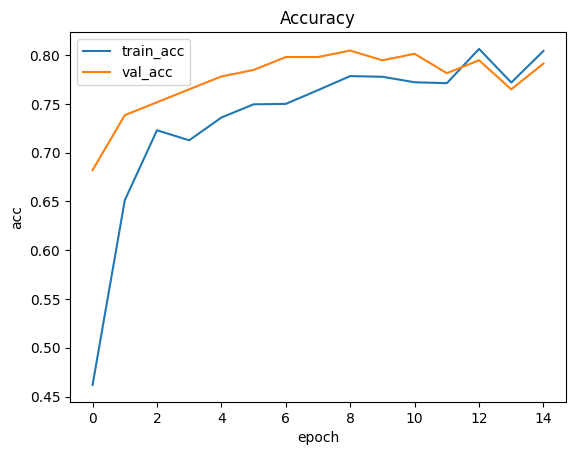

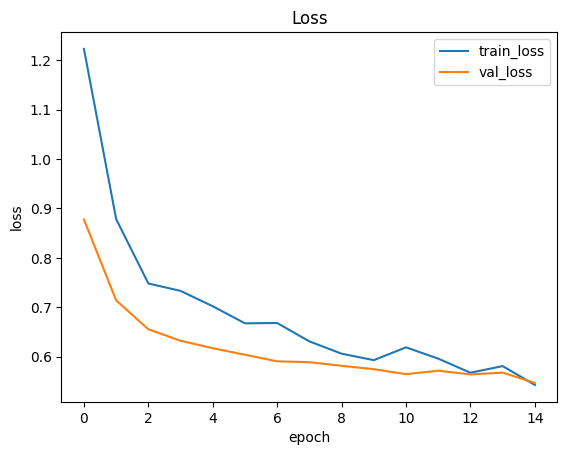

In [ ]:
ckpt_path = "waste_best.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy",
                                    save_best_only=True, mode="max", verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                  restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                                      patience=2, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

# Plot training curves (optional)
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.show()


In [ ]:
# Unfreeze top ~30% of EfficientNet layers
base.trainable = True
for layer in base.layers[: round(0.7 * len(base.layers))]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # lower LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
     37/Unknown 165s 4s/step - accuracy: 0.6871 - loss: 0.8160
Epoch 1: val_accuracy did not improve from 0.80464
37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.6879 - loss: 0.8144 - val_accuracy: 0.7781 - val_loss: 0.5792 - learning_rate: 1.0000e-04
Epoch 2/10
38/37 ━━━━━━━━━━━━━━━━━━━━ -3s 4s/step - accuracy: 0.7400 - loss: 0.6588
Epoch 2: val_accuracy improved from 0.80464 to 0.81126, saving model to waste_best.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - accuracy: 0.7407 - loss: 0.6581 - val_accuracy: 0.8113 - val_loss: 0.5407 - learning_rate: 1.0000e-04
Epoch 3/10
35/37 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.8022 - loss: 0.5125 
Epoch 3: val_accuracy did not improve from 0.81126
37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.8023 - loss: 0.5135 - val_accuracy: 0.8046 - val_loss: 0.5247 - learning_rate: 1.0000e-04
Epoch 4/10
36/37 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8175 - loss: 0.5156
Epoch 4: val_accuracy did not improve from 0.81126
3

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8909 - loss: 0.3863
Test Accuracy: 0.8523


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step
                precision    recall  f1-score   support

     Hazardous       0.89      0.95      0.92        44
Non-Recyclable       0.81      0.85      0.83        52
       Organic       0.89      0.83      0.86        48
    Recyclable       0.80      0.75      0.77        32

      accuracy                           0.85       176
     macro avg       0.85      0.85      0.85       176
  weighted avg       0.85      0.85      0.85       176



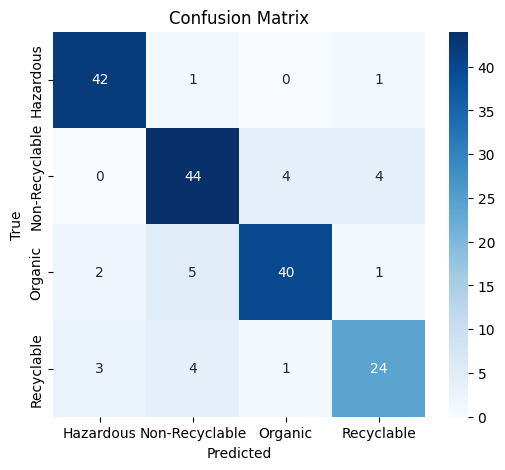

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("waste_classifier.h5")


In [ ]:
# Recommended (new format)
model.save("waste_classifier.keras")


In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("waste_best.keras", compile=False)
print("model.input_shape:", model.input_shape)   # e.g. (None, 225, 225, 3) or (...,1)
model.summary()

# find first Conv2D and print its kernel shape
first_conv = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        first_conv = layer
        break

if first_conv is not None:
    w = first_conv.get_weights()[0]   # kernel: (kh, kw, in_channels, out_channels)
    print("First Conv2D layer:", first_conv.name)
    print("Kernel shape (kh,kw,in_ch,out_ch):", w.shape)
else:
    print("No Conv2D layer found; check model input layer directly.")


ValueError: File not found: filepath=waste_best.keras. Please ensure the file is an accessible `.keras` zip file.

In [2]:
import os
print(os.listdir())


['.config', 'sample_data']


In [3]:
!find / -name "waste_best*"


find: ‘/proc/72/task/72/net’: Invalid argument
find: ‘/proc/72/net’: Invalid argument


In [4]:
!ls -lh


total 4.0K
drwxr-xr-x 1 root root 4.0K Sep  5 13:36 sample_data


In [5]:
from google.colab import files
uploaded = files.upload()


Saving waste_best.keras to waste_best.keras


In [6]:
from tensorflow.keras.models import load_model

# Load without compiling to avoid optimizer issues
model = load_model("waste_best.keras", compile=False)

# Check input shape
print("✅ Model input shape:", model.input_shape)

# Show architecture
model.summary()


✅ Model input shape: (None, 224, 224, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
import numpy as np
import tensorflow as tf

# Load and preprocess one image
img = tf.keras.utils.load_img("aerosolrecycling.jpg", target_size=(224, 224))   # replace with your image path
img_array = tf.keras.utils.img_to_array(img) / 255.0   # normalize
img_array = np.expand_dims(img_array, axis=0)          # (1, 224, 224, 3)

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)

print("Raw prediction scores:", pred)
print("Predicted class index:", predicted_class)


FileNotFoundError: [Errno 2] No such file or directory: 'aerosolrecycling.jpg'

In [9]:
from google.colab import files
uploaded = files.upload()


Saving download.jpg to download.jpg


In [10]:
!ls -lh


total 17M
-rw-r--r-- 1 root root  11K Sep  9 15:52 download.jpg
drwxr-xr-x 1 root root 4.0K Sep  5 13:36 sample_data
-rw-r--r-- 1 root root  17M Sep  9 15:43 waste_best.keras


In [12]:
import tensorflow as tf
import numpy as np

img = tf.keras.utils.load_img("download.jpg", target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)

print("Raw prediction scores:", pred)
print("Predicted class index:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Raw prediction scores: [[0.47120574 0.27736777 0.05272817 0.19869831]]
Predicted class index: [0]


In [13]:
class_names = ["Hazardous", "Non-Recyclable", "Organic", "Recyclable"]  # <-- replace with your real labels

predicted_label = class_names[predicted_class[0]]

print("Predicted class:", predicted_label)


Predicted class: Hazardous


In [15]:
def predict_image(image_path, model, class_names):
    import tensorflow as tf
    import numpy as np

    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred)

    return class_names[predicted_class], confidence, pred

# Example use:
class_names = ["Hazardous", "Non-Recyclable", "Organic", "Recyclable"]  # replace with yours
label, conf, raw = predict_image("download.jpg", model, class_names)

print(f"✅ Predicted: {label} ({conf:.2f} confidence)")
print("Raw scores:", raw)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
✅ Predicted: Hazardous (0.47 confidence)
Raw scores: [[0.47120574 0.27736777 0.05272817 0.19869831]]


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [17]:
test_dir = "/content/drive/MyDrive/datasets/waste_split/test"


In [18]:
import tensorflow as tf

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),  # must match your training size
    batch_size=32,
    shuffle=False
)

class_names = test_ds.class_names
print("Class names:", class_names)


Found 422 files belonging to 4 classes.
Class names: ['Hazardous', 'Non-Recyclable', 'Organic', 'Recyclable']


In [20]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

loss, acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {acc:.2%}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.7747 - loss: 0.6030
✅ Test Accuracy: 78.91%


In [21]:
loss, acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {acc:.2%}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7747 - loss: 0.6030
✅ Test Accuracy: 78.91%


14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step


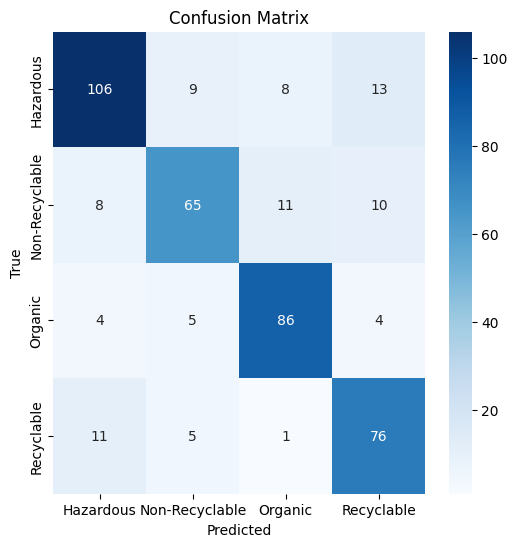

                precision    recall  f1-score   support

     Hazardous       0.82      0.78      0.80       136
Non-Recyclable       0.77      0.69      0.73        94
       Organic       0.81      0.87      0.84        99
    Recyclable       0.74      0.82      0.78        93

      accuracy                           0.79       422
     macro avg       0.79      0.79      0.79       422
  weighted avg       0.79      0.79      0.79       422



In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Detailed report
print(classification_report(y_true, y_pred, target_names=class_names))


In [24]:
import os

# Adjust path depending on how you mounted Google Drive
train_dir = "/content/drive/MyDrive/datasets/waste_split/train"

for cls in os.listdir(train_dir):
    count = len(os.listdir(os.path.join(train_dir, cls)))
    print(f"{cls}: {count}")


Hazardous: 641
Recyclable: 440
Non-Recyclable: 438
Organic: 447


In [27]:
val_dir = "/content/drive/MyDrive/datasets/waste_split/val"  # update path if needed

from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),  # or your model's input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)


Found 426 images belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


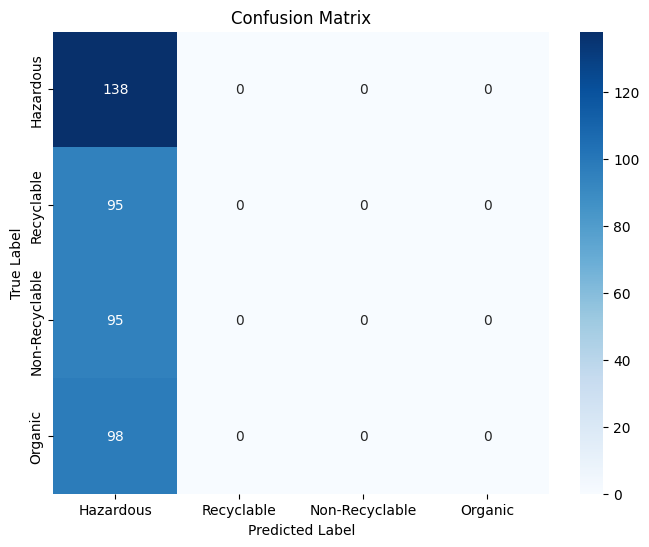

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on validation set
y_true = []
y_pred = []

for i in range(len(val_ds)):
    images, labels = val_ds[i]
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Hazardous', 'Recyclable', 'Non-Recyclable', 'Organic']

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


In [29]:
base_model = model.get_layer("efficientnetb0")
for layer in base_model.layers[-50:]:
    layer.trainable = True


In [30]:
from sklearn.utils import class_weight
import numpy as np

# Assuming y_train contains integer labels
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

# Pass class_weights=class_weights in model.fit()


NameError: name 'y_train' is not defined

In [31]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # or 'sparse' if integer labels
    shuffle=True
)

# For class_weight, you need integer labels, not one-hot
y_train = train_generator.classes


NameError: name 'train_datagen' is not defined

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [34]:
train_dir = "/content/drive/MyDrive/datasets/waste_split/train"
val_dir = "/content/drive/MyDrive/datasets/waste_split/val"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' to get integer labels
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Get integer labels for class weights
y_train = train_generator.classes


Found 1966 images belonging to 4 classes.
Found 426 images belonging to 4 classes.


In [35]:
from sklearn.utils import class_weight
import numpy as np

# y_train already comes from train_generator.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.766770670826833), 1: np.float64(1.1221461187214612), 2: np.float64(1.099552572706935), 3: np.float64(1.1170454545454545)}


In [39]:
from tensorflow.keras.optimizers import Adam

# Unfreeze last 50 layers if not done yet
base_model = model.get_layer("efficientnetb0")
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile model with low LR for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',  # integer labels
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights
)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 319s 5s/step - accuracy: 0.2863 - loss: 1.3917 - val_accuracy: 0.2418 - val_loss: 1.4219
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.2860 - loss: 1.3760 - val_accuracy: 0.2230 - val_loss: 1.4728
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.2881 - loss: 1.3933 - val_accuracy: 0.2230 - val_loss: 1.4656
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 281s 5s/step - accuracy: 0.2799 - loss: 1.3793 - val_accuracy: 0.2254 - val_loss: 1.4908
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - accuracy: 0.2859 - loss: 1.3958 - val_accuracy: 0.2230 - val_loss: 1.4495
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.2739 - loss: 1.3925 - val_accuracy: 0.2254 - val_loss: 1.4365
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.2941 - loss: 1.3833 - val_accuracy: 0.2864 - val_loss: 1.4072
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 281s 5s/step - accuracy: 0.2858 - loss: 1.3874 - val_accuracy: 0.2770 - v

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normal augmentation (for large/dominant classes)
normal_datagen = ImageDataGenerator(
    rescale=1./255
)

# Aggressive augmentation (for minority classes)
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [41]:
import numpy as np
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class CustomDataGenerator(Sequence):
    def __init__(self, data_dir, batch_size=32, target_size=(224,224)):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.classes = sorted(os.listdir(data_dir))
        self.filepaths = []
        self.labels = []
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(data_dir, cls)
            files = [os.path.join(cls_path, f) for f in os.listdir(cls_path)]
            self.filepaths.extend(files)
            self.labels.extend([idx]*len(files))
        self.indices = np.arange(len(self.filepaths))

        # Define datagens
        self.normal_datagen = normal_datagen
        self.aug_datagen = aug_datagen

    def __len__(self):
        return int(np.ceil(len(self.filepaths) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = []
        batch_y = []
        for i in batch_indices:
            img = load_img(self.filepaths[i], target_size=self.target_size)
            img_array = img_to_array(img)
            label = self.labels[i]

            # Apply aggressive augmentation for minority classes
            if label != 0:  # assuming class 0 = Hazardous
                img_array = self.aug_datagen.random_transform(img_array)

            img_array /= 255.0  # rescale
            batch_x.append(img_array)
            batch_y.append(label)

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)


In [42]:
train_dir = "/content/drive/MyDrive/datasets/waste_split/train"
val_dir = "/content/drive/MyDrive/datasets/waste_split/val"

batch_size = 32
target_size = (224,224)

train_generator = CustomDataGenerator(train_dir, batch_size=batch_size, target_size=target_size)

# Validation generator (no augmentation, only rescale)
val_generator = normal_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Get y_train for class weights
y_train = train_generator.labels


Found 426 images belonging to 4 classes.


In [43]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.766770670826833), 1: np.float64(1.1221461187214612), 2: np.float64(1.099552572706935), 3: np.float64(1.1170454545454545)}


In [44]:
# Assuming your model has a layer named 'efficientnetb0'
base_model = model.get_layer("efficientnetb0")

# Unfreeze last 100 layers for better adaptation
for layer in base_model.layers[-100:]:
    layer.trainable = True


In [45]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # very low LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [46]:
history = model.fit(
    train_generator,
    epochs=20,   # increase epochs for fine-tuning
    validation_data=val_generator,
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 1/62 ━━━━━━━━━━━━━━━━━━━━ 41:47 41s/step - accuracy: 0.2812 - loss: 1.6290

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


39/62 ━━━━━━━━━━━━━━━━━━━━ 1:50 5s/step - accuracy: 0.2749 - loss: 1.5004

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


62/62 ━━━━━━━━━━━━━━━━━━━━ 371s 5s/step - accuracy: 0.2812 - loss: 1.4853 - val_accuracy: 0.3239 - val_loss: 1.5171
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.3259 - loss: 1.4145 - val_accuracy: 0.3239 - val_loss: 1.4579
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 395s 5s/step - accuracy: 0.3223 - loss: 1.4090 - val_accuracy: 0.3239 - val_loss: 1.4420
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 317s 5s/step - accuracy: 0.3079 - loss: 1.3994 - val_accuracy: 0.3099 - val_loss: 1.3867
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.3354 - loss: 1.3875 - val_accuracy: 0.2160 - val_loss: 1.4335
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 0.3258 - loss: 1.3777 - val_accuracy: 0.2254 - val_loss: 1.4472
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.3383 - loss: 1.3564 - val_accuracy: 0.3451 - val_loss: 1.3992
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.3358 - loss: 1.3601 - val_accuracy: 0.3732 - val_loss: 1.

In [ ]:
import pathlib

bad_files = []
for folder in ["train", "val", "test"]:6
path = pathlib.Path(DATA_DIR) / folder
for f in path.rglob("*"):
        if f.is_file():
            if not f.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".gif"]:
                bad_files.append(str(f))

print("Found", len(bad_files), "non-image files")
for f in bad_files[:20]:
    print(f)


Found 0 non-image files


In [ ]:
for f in bad_files:
    os.remove(f)


In [ ]:
from PIL import Image

for folder in ["train", "val", "test"]:
    path = pathlib.Path(DATA_DIR) / folder
    for f in path.rglob("*.jpg"):
        try:
            img = Image.open(f)
            img.verify()
        except Exception as e:
            print("Corrupted:", f, e)


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
from PIL import Image
import pathlib, os

corrupted = []
for folder in ["train", "val", "test"]:
    path = pathlib.Path(DATA_DIR) / folder
    for f in path.rglob("*.*"):
        try:
            img = Image.open(f)
            img.verify()  # check if image is valid
        except Exception as e:
            print("Corrupted:", f, e)
            corrupted.append(f)

print("Total corrupted files:", len(corrupted))

# remove them if you want
for f in corrupted:
    os.remove(f)


Total corrupted files: 0


In [ ]:
import pathlib

tiffs = []
for folder in ["train", "val", "test"]:
    path = pathlib.Path(DATA_DIR) / folder
    for f in path.rglob("*.tif*"):  # catches .tif and .tiff
        tiffs.append(f)

print("Found", len(tiffs), "TIFF files")
for f in tiffs:
    print(f)


Found 0 TIFF files


In [ ]:
train_ds = train_ds.apply(tf.data.experimental.ignore_errors())
val_ds   = val_ds.apply(tf.data.experimental.ignore_errors())
test_ds  = test_ds.apply(tf.data.experimental.ignore_errors())


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [ ]:
train_ds = train_ds.ignore_errors()
val_ds   = val_ds.ignore_errors()
test_ds  = test_ds.ignore_errors()
